In [147]:
from osgeo import gdal, gdalnumeric, ogr, osr
from gdalconst import *
from PIL import Image, ImageDraw
import os
import numpy as np
import subprocess

%matplotlib inline
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

from library._04_geoprocess_cities import clip_raster

In [ ]:
input_shp = '/Users/peter/Dropbox/ds/gh/metis_projects/05-final/test/eth.shp'
input_tif = '/Users/peter/Dropbox/ds/gh/metis_projects/05-final/test/_1992.tif'
output_tif = '/Users/peter/Dropbox/ds/gh/metis_projects/05-final/test/output.tif'

# Test has been moved to geo folder
## remember to polygonize

In [133]:
# use this in the for loop to build path to io files: input_shp = os.path.abspath('test') + '/eth.shp'; input_shp
subprocess.check_call(['gdalwarp', '-dstnodata', '255', '-q', '-cutline', input_shp, '-crop_to_cutline', '-of', 'GTiff', input_tif, output_tif])

0

In [2]:
# clip raster with country shapefile
rast = gdal.Open('_1992.tif', GA_ReadOnly)
shp_path = 'data/geo/countries/eth.shp'
eth = clip_raster(rast, shp_path); eth

(array([[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ..., 
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]], dtype=uint8),
 25559,
 7214,
 [32.98979984500011,
  0.0083333333,
  0.0,
  14.879532166000061,
  0.0,
  -0.0083333333])

In [196]:
pixel_vals = eth[0].flatten()  # flatten pixels

def filter_nodata(vals, no_data_val):  # filter function to remove zeros and nodata values from numpified raster values
    return vals != no_data_val
bool_arr_1 = np.array([filter_nodata(val, 255) for val in pixel_vals])
pixel_vals_nd_1 = pixel_vals[bool_arr_1]

bool_arr_2 = np.array([filter_nodata(val, 0) for val in pixel_vals_nd_1]) 
pixel_vals_nd_2 = pixel_vals_nd_1[bool_arr_2]

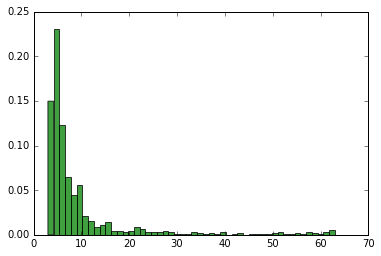

In [198]:
# see what resulting histogram of data looks like
n, bins, patches = plt.hist(pixel_vals_nd_2, 50, normed=1, facecolor='green', alpha=0.75)

In [166]:
from scipy.stats import expon
import math

In [200]:
np.mean(pixel_vals_nd_2)

9.6963288108539505

In [212]:
# fit exponential curve to data, inspect raster data in qgis
# see what percent of non-zero pixels constitute cities at given cutoff threshold
params = expon.fit(pixel_vals_nd_2)
the_mean = params[1]
the_lambda = 1 / the_mean
thresh = 25
1 - math.exp(-thresh*the_lambda)

0.9760881747105427

In [17]:
# OLD, DOES NOT WORK

# register all of the GDAL drivers
gdal.AllRegister()

# Write clip outputs to geotiff
nrows, ncols = np.shape(eth[0])
array = eth[0]
x_ul = eth[3][0]
y_ul = eth[3][3]
x_res = eth[3][1]
y_res = eth[3][-1]
geotransform = (x_ul, x_res, 0, y_ul, 0, y_res)

output_raster = gdal.GetDriverByName('GTiff').Create('new.tif', ncols, nrows, 1, gdal.GDT_Float32)  # Open the file
output_raster.SetGeoTransform(geotransform)  # Specify its coordinates

srs = osr.SpatialReference()                 # Establish its coordinate encoding
srs.ImportFromEPSG(4326)                     # This one specifies WGS84 lat long.
output_raster.SetProjection( srs.ExportToWkt() )   # Exports the coordinate system 
                                                   # to the file
output_raster.GetRasterBand(1).SetNoDataValue(255)
output_raster.GetRasterBand(1).WriteArray(array)   # Writes my array to the raster

# polygonize geotiff
!gdal_polygonize.py myraster.tif -f 'ESRI Shapefile' mypoly.shp

0